In [43]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
from tqdm import tqdm
import wandb
import os
import gym
from train_ppo import train_ppo
from models.dqn import D3QN
from models.ppo import PPO
from env.wei_obs_grid import WeightedObsGrid
from utils.utils import uniform_weight, normal_weight, NormalWeightGrid
import pickle
from baseline.dijkstra import dijkstra_grid_with_weights, reconstruct_path
import copy


## Load Env

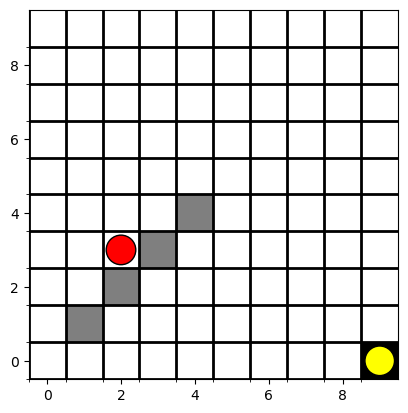

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [44]:
env = pickle.load(open('env_end_rand.pkl', 'rb'))
env.render()
print(env.state['obstacles'])

In [45]:
actor_lr = 1e-4
critic_lr = 5e-3
num_episodes = 5000
hidden_dim = 3
gamma = 0.9
epsilon = 0.2
lmbda = 0.9
epochs = 10
reset_interval = 5000
max_steps = 500
state_dim = (4, env.grid_size[0], env.grid_size[1])
action_dim = 4
agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, gamma, epsilon, lmbda, epochs, device='cuda:0')
agent.load_state_dict(torch.load('saved_model/ppo_model_milp.pth'))

<All keys matched successfully>

In [46]:
from milp_code.alloc_veh import AllocVeh
from milp_code.utils import rand_create_Boxes, rand_gener_map, gener_map_list
from collections import defaultdict

In [47]:
loc_set = [(3, 2), (3, 6), (6, 2),(9, 9)]

In [48]:
locs = gener_map_list(loc_set)
boxes = rand_create_Boxes([1, 3], 4, 2)
init_point = 0

In [49]:
done = False
iter_num = 0
drl_cost = defaultdict(float)
drl_path = defaultdict(list)

for i in range(4):
    for j in range(4):
        if i == j:
            continue
        trajectory = []
        env.state['current_position'] = np.array(loc_set[i])
        env.state['goal_position'] = np.array(loc_set[j])
        state = env.processed_state()
        done = False
        while not done:
            iter_num += 1
            eligibles = env.eligible_action_idxes()
            if len(eligibles) == 0:
                break
            action = agent.take_action_eval(state, eligibles, strategy='greedy')

            next_state, reward, done, _ = env.step(action)
            state = next_state
            trajectory.append(env.state['current_position'])
            drl_cost[i,j] += env.state['weight'][int(env.state['current_position'][0])][int(env.state['current_position'][1])]
        drl_path[i,j] = trajectory
    

In [50]:
print('DRL cost:', drl_cost)
dist = [drl_cost[i,j] if i != j else 10 for i in range(4) for j in range(4)]

DRL cost: defaultdict(<class 'float'>, {(0, 1): 1.0189663712183161, (0, 2): 0.9265269169771526, (0, 3): 0.8449985229481933, (1, 0): 4.54863540145615, (1, 2): 3.3232360285736027, (1, 3): 3.7895433875121425, (2, 0): 1.1627995748928082, (2, 1): 1.3033473845658374, (2, 3): 1.5614784681541596, (3, 0): 6.896534291181987, (3, 1): 5.94826572200563, (3, 2): 6.988257940501834})


In [51]:
alloc_class = AllocVeh(init_point, locs, boxes, dist)

Cardinal Optimizer v7.0.6. Build date Jan 16 2024
Copyright Cardinal Operations 2023. All Rights Reserved

Initializing model, 4 locations and 2 boxes


Model constructed successfully
Model fingerprint: 7b922523

Using Cardinal Optimizer v7.0.6 on Linux
Hardware has 96 cores and 192 threads. Using instruction set X86_AVX512_E1 (14)
Minimizing a MIP problem

The original problem has:
    31 rows, 18 columns and 131 non-zero elements
    18 binaries

Presolving the problem
Problem was solved during presolve

Best solution   : 2659.000000000
Best bound      : 2659.000000000
Best gap        : 0.0000%
Solve time      : 0.01
Solve node      : 0
MIP status      : solved
Solution status : integer optimal (relative gap limit 0.0001)

Violations      :     absolute     relative
  bounds        :            0            0
  rows          :            0            0
  integrality   :            0
Model solved


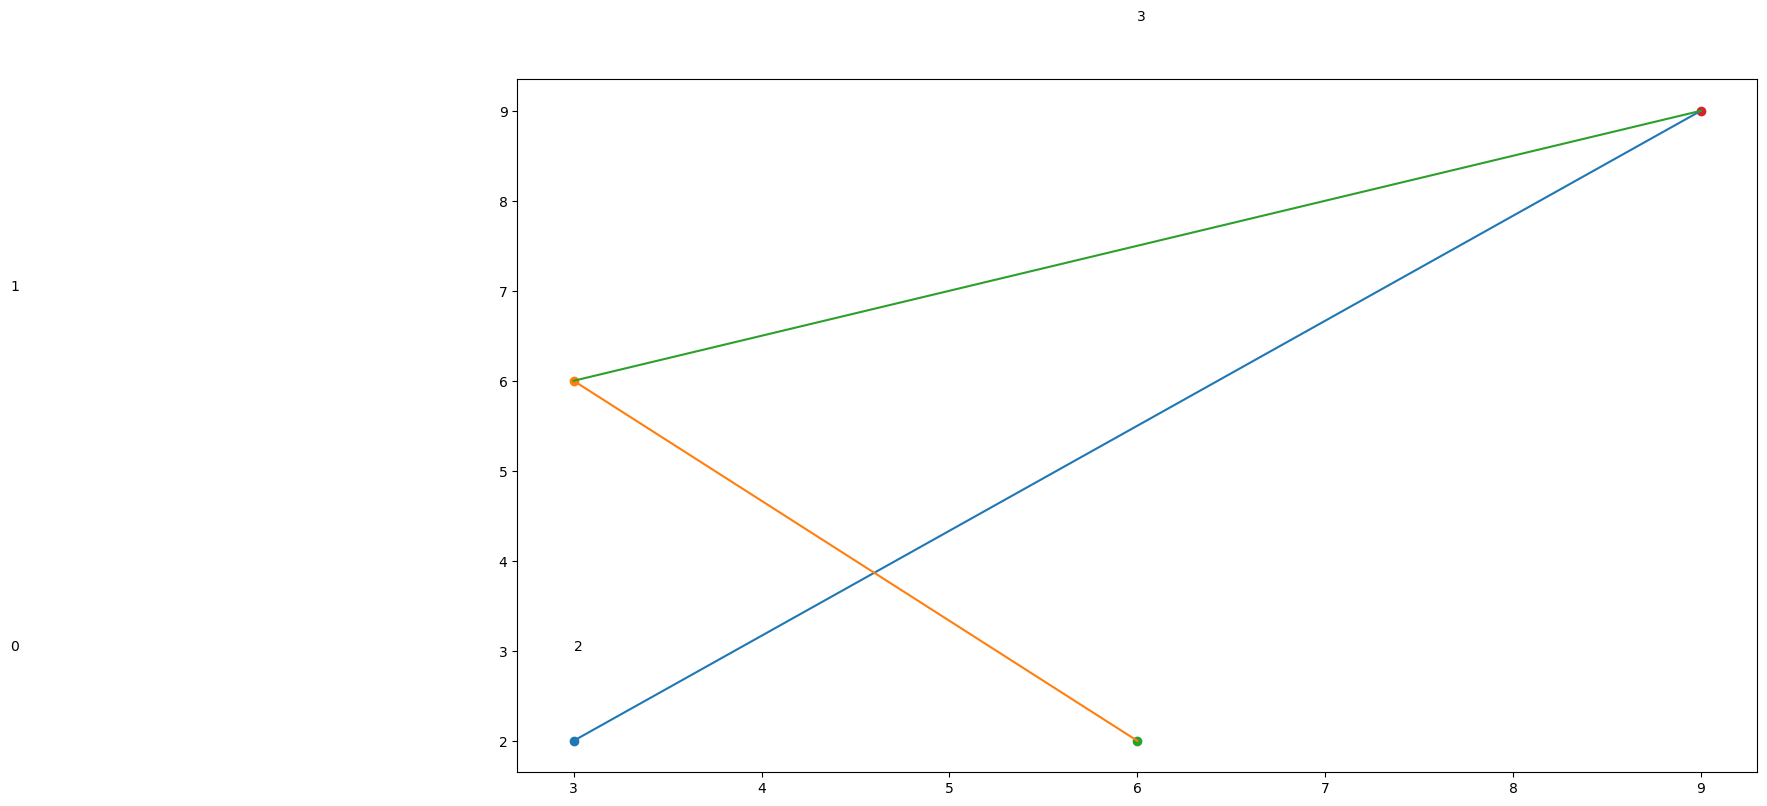

<Figure size 640x480 with 0 Axes>

In [52]:
alloc_class.construct_model()
opt = alloc_class.solve(True)
alloc_class.draw_locations_opt()

## Restore Path

In [53]:
path = [init_point]
for _ in range(opt[0].shape[0]-1):
    path.append(opt[0][path[-1]].nonzero()[0][0])

In [54]:
path

[0, 3, 1, 2]

In [55]:
micro_path = [np.array(loc_set[path[0]])]
for i in range(4):
    for j in range(i+1, 4):
        st = path[i]
        ed = path[j]

        env.state['current_position'] = np.array(loc_set[st])
        env.state['goal_position'] = np.array(loc_set[ed])
        state = env.processed_state()
        done = False
        while not done:
            iter_num += 1
            eligibles = env.eligible_action_idxes()
            if len(eligibles) == 0:
                break
            action = agent.take_action_eval(state, eligibles, strategy='greedy')

            next_state, reward, done, _ = env.step(action)
            state = next_state
            micro_path.append(env.state['current_position'])
            
    

## 总路线（中微观）【可能有些重复看不清】

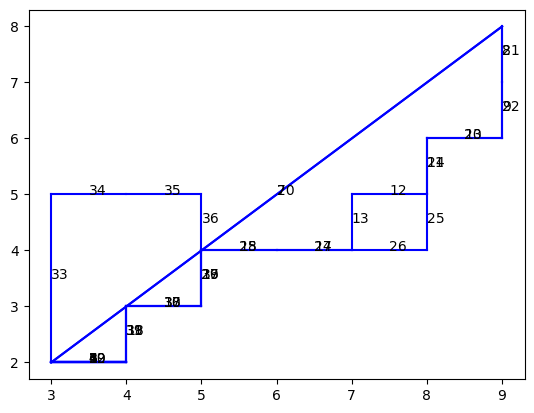

In [56]:
import matplotlib.pyplot as plt

locations = micro_path

plt.figure()

for i in range(len(locations) - 1):

    current_location = locations[i]
    next_location = locations[i + 1]

    x_line = (current_location[0], next_location[0])
    y_line = (current_location[1], next_location[1])

    plt.plot(x_line, y_line, color='blue')

    mid_point = ((current_location[0] + next_location[0]) / 2, (current_location[1] + next_location[1]) / 2)

    plt.text(mid_point[0], mid_point[1], str(i + 1))

# 显示图形
plt.show()